In [ ]:
!pip install sox
!pip install pydub
!pip install librosa
!pip install pomegranate
!pip install faiss

In [99]:
import librosa as rosa
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
import scipy as sp
import scipy.stats as sstats
import pandas as pd
import pomegranate as pg
import pickle
import os
import pydub
import sox
import datetime
import faiss

from warnings import warn
from tqdm.auto import tqdm


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn import tree
from pomegranate import HiddenMarkovModel
from pomegranate.distributions import DiscreteDistribution
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

%matplotlib inline

# Preprocessing first method

In [ ]:
dataDirPath="../data/"
namesMainParts=["1","2","3"]
audioFilePrefix="audio"
audioFileSufix=".wav"
labelFilePrefix="labels"
labelFileSufix=".txt"

In [ ]:
subfragmentsDir="../subfragments/"
sortedSubfragmentsDir="../sortedSubfragments/"
subfragmentLengthInSeconds=1
# ratio used to calculate muber of subfragments to generate from fragment
# if L is length of fragment in second, S length of subfragment in seconds
# then from this subfragment will be generated L/S*subfragToFragLengthRatio+1 subfragments
subfragToFragLengthRatio=0.5

In [ ]:
typeList=["m","s","j","sm","pc"]

In [ ]:
os.makedirs(sortedSubfragmentsDir, exist_ok=True)
for typ in typeList:
    os.makedirs(sortedSubfragmentsDir+typ, exist_ok=True)

## Label Parsing

In [ ]:
def parseLabelFile(pathToFile):
    startsOfFragments={"m":[], "s":[], "j":[], "sm":[], "pc":[]}
    with open(pathToFile, "r") as labelFile:
        labelFile.readline()
        for line in labelFile:
            line=line[:-1]
            listedLine=line.split(",")
            if listedLine[-1]=="":
                listedLine=listedLine[:-1]
            timestamp=listedLine[0].split(":")
            timeInSeconds=int(timestamp[-1])+int(timestamp[-2])*60+int(timestamp[-3])*3600
            if listedLine[1]=="silence":
                continue
            elif listedLine[1]=="music":
                if len(listedLine)>2:
                    if listedLine[2]=="jingle":
                        startsOfFragments["j"].append(timeInSeconds)
                        continue
                    else:
                        warn(RuntimeWarning("Second argument isn't recognized: "+listedLine[2]))
                startsOfFragments["m"].append(timeInSeconds)
            elif listedLine[1]=="speech":
                if len(listedLine)>2:
                    if listedLine[2]=="musicinthebackground":
                        startsOfFragments["sm"].append(timeInSeconds)
                        continue
                    elif listedLine[2]=="phonecall":
                        startsOfFragments["pc"].append(timeInSeconds)
                        continue
                    else:
                        warn(RuntimeWarning("Second argument isn't recognized: "+listedLine[2]))
                startsOfFragments['s'].append(timeInSeconds)
            else:
                warn(RuntimeWarning("Type argument isn't recognized: "+listedLine[1]))
    return startsOfFragments

In [ ]:
class AudioFragment:
    def __init__(self, typ, audio, startPointInSec, fileName,sr):
        self.typ=typ
        self.audio=audio
        self.startPoint=startPointInSec
        self.fileName=fileName
        self.sr=sr
    def drawSubfragment(self, lengthInSeconds):
        lengthInProbes=self.sr*lengthInSeconds
        if len(self.audio)<lengthInProbes:
            raise RuntimeError("Fragment is to short to generate requested length.")
        index=np.random.randint(0,len(self.audio)-lengthInProbes+1)
        return self.audio[index:index+lengthInProbes].copy()
    def getLengthInSeconds(self):
        return len(self.audio)/self.sr

In [ ]:
class SubfragmentIndex:
    def __init__(self):
        self.numberOfSubfragments=0
        self.subfragmentsByType={"m":[], "s":[], "j":[], "sm":[], "pc":[]}
    def getNextNumberOfSubfragment(self):
        return self.numberOfSubfragments+1
    def addNewSubfragmentToIndex(self, subfragmentPath, subfragmentTyp):
        self.numberOfSubfragments+=1
        self.subfragmentsByType[subfragmentTyp].append(subfragmentPath)
        return
    def drawRandomSubfragment(self):
        r=np.random.randint(0, self.numberOfSubfragments)
        for typ in self.subfragmentsByType:
            if r>len(self.subfragmentsByType[typ]):
                r-=len(self.subfragmentsByType[typ])
            else:
                return self.subfragmentsByType[typ][r]
        raise RuntimeError("Something went wrong")
    def drawRandomByType(self, typ):
        r=np.random.randint(0, len(self.subfragmentsByType[typ]))
        return self.subfragmentsByType[typ][r]

In [ ]:
def generateSubfragments():
    subfInd=SubfragmentIndex()
    for name in namesMainParts:
        audioFilePath=dataDirPath+audioFilePrefix+name+audioFileSufix
        labelFilePath=dataDirPath+labelFilePrefix+name+labelFileSufix
        audio, sr=rosa.load(audioFilePath)
        if (sr!=22050):
            warn("Sapling rate of file: "+audioFilePath+" is diffrent than 22050.")
        startOfFragmentsDict=parseLabelFile(labelFilePath)

        sortedListOfStarts=[]
        for typ in startOfFragmentsDict:
            sortedListOfStarts.extend(startOfFragmentsDict[typ])
        sortedListOfStarts.sort()

        for typ in startOfFragmentsDict:
            for start in startOfFragmentsDict[typ]:
                index=sortedListOfStarts.index(start)
                if index+1==len(sortedListOfStarts):
                    end=int(len(audio)/sr)
                else:
                    end=sortedListOfStarts[index+1]
                af=(AudioFragment(typ, audio[start*sr:end*sr], start, audioFilePath, sr))
                numberOfSubfragmentsToGenerate=int(af.getLengthInSeconds()/subfragmentLengthInSeconds*\
                    subfragToFragLengthRatio+1)
                try:
                    for i in range(numberOfSubfragmentsToGenerate):
                        subfragment=af.drawSubfragment(subfragmentLengthInSeconds)
                        subfragmentFFT=np.abs(rosa.stft(subfragment, hop_length=1024))
                        picklePath=subfragmentsDir+typ+"/"+str(subfInd.getNextNumberOfSubfragment())+".pickle"
                        with open(picklePath,"wb") as pickleFile:
                            pickle.dump(subfragmentFFT, pickleFile)
                        subfInd.addNewSubfragmentToIndex(picklePath, typ)
                except RuntimeError:
                    pass
    return subfInd

In [ ]:
def generateSubfragmentsSorted():
    subfInd=SubfragmentIndex()
    listOfPaths=[]
    for name in namesMainParts:
        audioFilePath=dataDirPath+audioFilePrefix+name+audioFileSufix
        labelFilePath=dataDirPath+labelFilePrefix+name+labelFileSufix
        audio, sr=rosa.load(audioFilePath)
        if (sr!=22050):
            warn("Sapling rate of file: "+audioFilePath+" is diffrent than 22050.")
        startOfFragmentsDict=parseLabelFile(labelFilePath)

        sortedListOfStarts=[]
        for typ in startOfFragmentsDict:
            sortedListOfStarts.extend(startOfFragmentsDict[typ])
        sortedListOfStarts.sort()

        for typ in startOfFragmentsDict:
            for start in startOfFragmentsDict[typ]:
                index=sortedListOfStarts.index(start)
                if index+1==len(sortedListOfStarts):
                    end=int(len(audio)/sr)
                else:
                    end=sortedListOfStarts[index+1]
                af=(AudioFragment(typ, audio[start*sr:end*sr], start, audioFilePath, sr))
                                
                for i in range(0, int(af.getLengthInSeconds()-2*subfragmentLengthInSeconds), 
                               subfragmentLengthInSeconds):
                    subfragment=af.audio[i*af.sr : (i+subfragmentLengthInSeconds)*af.sr]
                    subfragmentFFT=np.abs(rosa.stft(subfragment, hop_length=1024))
                    picklePath=sortedSubfragmentsDir+typ+"/"+str(subfInd.getNextNumberOfSubfragment())+".pickle"
                    with open(picklePath,"wb") as pickleFile:
                        pickle.dump(subfragmentFFT, pickleFile)
                    subfInd.addNewSubfragmentToIndex(picklePath, typ)
                    listOfPaths.append(picklePath)
    return subfInd, listOfPaths

In [ ]:
SI=generateSubfragments()

In [ ]:
SSI, listOfPaths=generateSubfragmentsSorted()

## Creating Testsets for predictor

In [ ]:
def createTestSet(subfragIndex, testSetSize, typeWeights, savePath):
    for typ in typeWeights:
        expectedNumber=typeWeights[typ]*testSetSize
        if len(subfragIndex.subfragmentsByType[typ])<expectedNumber:
            warn("There is less subfragments for type: "+typ+" than expected number of samples in dataset.")
    randomTypes=np.random.choice(len(typeWeights.keys()),size=testSetSize, p=list(typeWeights.values()))
    keys=list(typeWeights.keys())
    
    dataList=[]
    labelList=[]
    for randomTyp in randomTypes:
        typ=keys[randomTyp]
        randSubfPath=subfragIndex.drawRandomByType(typ)
        with open(randSubfPath, "rb") as pickleFile:
            dataList.append(pickle.load(pickleFile))
            labelList.append(typ)
    with open(savePath, "wb") as pickleFile:
        pickle.dump((dataList, labelList), pickleFile)

In [ ]:
def generateTestsSets(numberOfSets, sizes):
    for s in sizes:
        for i in range(numberOfSets):
            createTestSet(SI, s, {"m":0.5, "s":0.25, "j":0, "sm":0.125, "pc":0.125}, 
                          datasetDir+"dataset{}-{}.pickle".format(s,i))

In [ ]:
generateTestsSets(3, [1000])

## Creating Testsets for HMM

In [ ]:
testSetSize=int(len(listOfPaths)/3)
trainSetSize=len(listOfPaths)-testSetSize

trainDataList=[]
trainLabelList=[]
for i in range(trainSetSize):
    path=listOfPaths[i]
    typeOfPath=apth.split("/")[2]
    trainLabelList.append(typeOfPath)
    with open(path, "rb") as pickleFile:
        trainDataList.append(pickle.load(pickleFile))

testDataList=[]
testLabelList=[]
for i in range(testSetSize):
    path=listaSciezek[i+trainSetSize]
    typeOfPath=path.split("/")[2]
    testLabelList.append(typeOfPath)
    with open(path, "rb") as pickleFile:
        testDataList.append(pickle.load(pickleFile))   

# Preprocesing second method

In [ ]:
REPO_DIR = "/mnt/c/Users/zobni/Programming/UWrMLProjectAudioSeg/"
AUDIO_TYPE = ".wav"
SECOND = 1000

In [ ]:
os.chdir(REPO_DIR)
os.listdir(REPO_DIR + "/data")
for i in [1, 2, 3]:
    os.makedirs(REPO_DIR + "/data/audio{}".format(i), exist_ok=True)

## Audio1

In [ ]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio1.wav")
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio1/audio1_{}.wav".format(fragment[0] + 1), format="wav")
labels_df = pd.read_csv('data/labels1.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels1_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio1/audio1_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [ ]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_1.csv")

## Audio2

In [ ]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio2.wav")

In [ ]:
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]

In [ ]:
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio2/audio2_{}.wav".format(fragment[0] + 1), format="wav")

In [ ]:
labels_df = pd.read_csv('data/labels2.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels2_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio2/audio2_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [ ]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_2.csv")

## Audio3

In [ ]:
audio = pydub.AudioSegment.from_wav(REPO_DIR + "data/audio3.wav")

In [ ]:
new_audio = [audio[i * SECOND : (i + 1) * SECOND] for i in range(len(audio)//SECOND)]

In [ ]:
for fragment in enumerate(new_audio):
    fragment[1].export("data/audio3/audio3_{}.wav".format(fragment[0] + 1), format="wav")

In [ ]:
labels_df = pd.read_csv('data/labels3.txt')[['timestamp', 'label']]
labels_df['timestamp'] = labels_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, "%H:%M:%S"))
labels_df = labels_df.set_index('timestamp')
labels_df = labels_df.resample('1S').pad()
labels_df['seconds'] = labels_df.index
labels_df['seconds'] = labels_df['seconds'].apply(lambda x: int((x - datetime.datetime(1900, 1, 1)).total_seconds()))
labels_df.to_csv(REPO_DIR + '/data/labels3_long.csv', index=False)

In [ ]:
rows = []
for second in tqdm(labels_df['seconds']):
    y, sr = librosa.load(REPO_DIR + "data/audio3/audio3_{}.wav".format(second))
    label = labels_df[labels_df['seconds'] == second]['label'][0]
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    rmse = np.mean(librosa.feature.rms(y=y))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfccs = []
    for e in mfcc:
        mfccs.append(np.mean(e))
    obs = [second, label, rmse, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    obs.extend(mfccs)
    rows.append(obs)

In [ ]:
columns = ['timestamp', 'label', 'chroma_stft', 'rmse', 'spec_cent', 'spec_bw', 'rolloff', 'zcr']
columns.extend(['mfcc_{}'.format(i) for i in range(len(mfcc))])
data = pd.DataFrame(rows, columns = columns)
data.head()
data.to_csv(REPO_DIR + "/data/data_3.csv")

# Class Spectograms

In [116]:
with open('../data/dataset/dataset1000-0.pickle', 'rb') as f:
    dataset = pickle.load(f)

pc


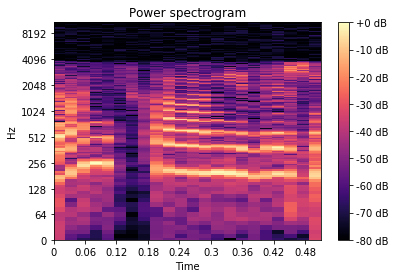

In [117]:
k = 3
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

m


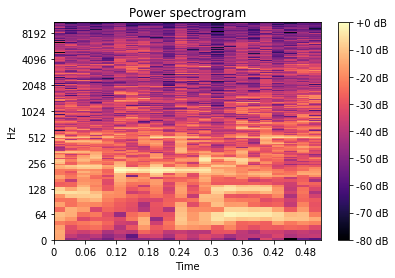

In [118]:
k = 13
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

s


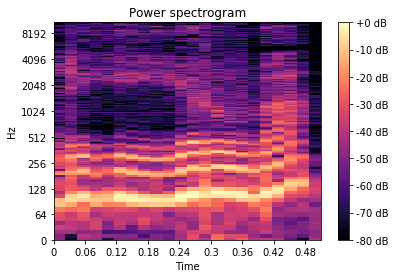

In [119]:
k = 7
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

sm


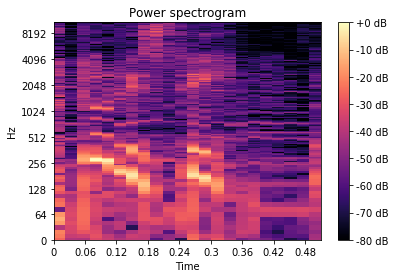

In [120]:
k = 1
exampleSpectrogram = dataset[0][k]
exampleLabel = dataset[1][k]
print(exampleLabel)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(exampleSpectrogram,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Learning & Evaluation - Supervised - Preprocessing 1

In [135]:
with open('../data/dataset/dataset1000-0.pickle', 'rb') as f:
    dataset_1 = pickle.load(f)
    
with open('../data/dataset/dataset1000-1.pickle', 'rb') as f:
    dataset_2 = pickle.load(f)

with open('../data/dataset/dataset1000-2.pickle', 'rb') as f:
    dataset_3 = pickle.load(f)

In [133]:
def transformLabels(dataset):
    labels = []
    for label in dataset[1]:
        if label=='pc' or label=='sm':
            labels.append('s')
        elif label=='j':
            labels.append('m')
        else:
            labels.append(label)

    return labels

In [137]:
labels = []
labels.extend(transformLabels(dataset_1))
labels.extend(transformLabels(dataset_2))
labels.extend(transformLabels(dataset_3))

In [139]:
data = []
data.extend(dataset_1[0])
data.extend(dataset_2[0])
data.extend(dataset_3[0])

In [143]:
trainX, testX, trainY, testY = train_test_split(np.array(data), np.array(labels), test_size = 0.2, random_state=42, stratify=labels)

## K-nearest neighbor

In [ ]:
ks = np.arange(2,3,4)

results = []

for k in tqdm(ks):
    knnClf = KNeighborsClassifier(n_neighbors=k)
    knnClf.fit(trainX.astype('float32').reshape(-1, 1025*22), trainY)
    trainPreds = knnClf.predict(trainX.astype('float32').reshape(-1, 1025*22))
    testPreds = knnClf.predict(testX.astype('float32').reshape(-1, 1025*22))
    
    results.append({'ks': k, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'ks': k, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

In [ ]:
sns.catplot(x = 'depth', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [ ]:
best_k = ks[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['ks'] == best_depth)]['score'])[0]))
knnClf = KNeighborsClassifier(n_neighbors=best_k)
knnClf.fit(trainX.astype('float32'), trainY)

## RandomForestClassifier

In [ ]:
depths = np.arange(5,51,5)
results = []
    
for depth in tqdm(depths): 
    rfClf = RandomForestClassifier(max_depth=depth, random_state=0)
    rfClf.fit(trainX, trainY)
    trainPreds = rfClf.predict(trainX)
    testPreds = rfClf.predict(testX)

    results.append({'depth': depth, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'depth': depth, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

In [ ]:
sns.catplot(x = 'depth', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [ ]:
best_depth = depths[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['depth'] == best_depth)]['score'])[0]))
rfClf = RandomForestClassifier(max_depth=best_depth, random_state=0)
rfClf.fit(trainX, trainY)

## Smoothing with HMM

In [ ]:
with open('../data/dataset/HMM-dataset-train.pickle', 'rb') as f:
    train_dataset = pickle.load(f)
    
with open('../data/dataset/HMM-dataset-test.pickle', 'rb') as f:
    test_dataset = pickle.load(f)

In [ ]:
train_X = np.concatenate([np.stack(train_dataset[0]).reshape(-1, 1025*22)])

train_y = np.concatenate([np.stack(train_dataset[1])])

test_X = np.stack(test_dataset[0]).reshape(-1, 1025*22)
test_y = np.stack(test_dataset[1])

del train_dataset
del test_dataset

In [ ]:
class smoothHMM:

    def __init__(self, predictor, state_names):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names

    def fit(self, X, y):
        
        X_prediction=self.predictor.predict(X)
        for i in range(len(X_prediction)):
            if X_prediction[i]=='pc' or X_prediction[i]=='sm':
                X_prediction[i]='s'
        X_simplified = self.le.fit_transform(X_prediction).reshape(1, -1)
        
        print(np.unique(X_simplified))
        for i in range(len(y)):
            if y[i]=='pc' or y[i]=='sm':
                y[i]='s'
            if y[i]=='j':
                y[i]='m'
                
        y = y.reshape(1, -1)

        
        print(np.unique(y))
        
        self.modelHMM = self.modelHMM.from_samples(DiscreteDistribution, 2, X_simplified, labels = y,
                                   algorithm='labeled', state_names=['m','s'], verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):
        X_prediction=self.predictor.predict(X)
        for i in range(len(X_prediction)):
            if X_prediction[i]=='pc' or X_prediction[i]=='sm':
                X_prediction[i]='s'
        X_simplified = self.le.transform(X_prediction).tolist()
        
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)
        
        for i in range(len(y)):
            if y[i]=='pc' or y[i]=='sm':
                y[i]='s'
            if y[i]=='j':
                y[i]='m'
                
        y = self.le.transform(y)
        
        return np.sum(target==y)/y.shape[0]

In [ ]:
hmm = smoothHMM(rfClf, state_names=['m', 'pc', 's', 'sm'])
hmm.fit(train_X, train_y)

In [ ]:
hmm.score(test_X, test_y)

In [ ]:
hmm = smoothHMM(knnClf, state_names=['m', 'pc', 's', 'sm'])
hmm.fit(train_X, train_y)

In [ ]:
hmm.score(test_X, test_y)

# Learning & Evaluation - Supervised - Preprocessing 2

In [65]:
REPO_DIR = "/mnt/c/Users/zobni/Programming/UWrMLPhttp://localhost:8888/notebooks/Notebooks/Raport.ipynb#Learning-&-Evaluation---Supervised---Preprocessing-2rojectAudioSeg/"
data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2,3]])
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [66]:
data.head()

,label,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,music,0.012444,0.081449,432.529692,424.989395,949.418501,0.01466,-632.946411,12.773681,-1.715082,...,-2.038454,-0.884550,-1.802255,0.243648,-0.727257,0.287844,0.141726,-0.364878,-0.763656,-0.566740
4,music,0.172535,0.435161,2309.434221,2392.904163,4963.403320,0.10235,-33.924923,96.108818,-15.746825,...,-10.182379,-11.484722,-13.531470,-5.707917,-9.890487,-1.513985,-8.121307,-4.673933,-4.060278,-2.206214


In [67]:
X = data.drop('label', axis=1)
y = data['label']

trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

## RandomForestClassifier

In [68]:
depths = np.arange(5,51,5)
results = []
    
for depth in tqdm(depths): 
    rfClf = RandomForestClassifier(max_depth=depth, random_state=0)
    rfClf.fit(trainX, trainY)
    trainPreds = rfClf.predict(trainX)
    testPreds = rfClf.predict(testX)

    results.append({'depth': depth, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'depth': depth, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

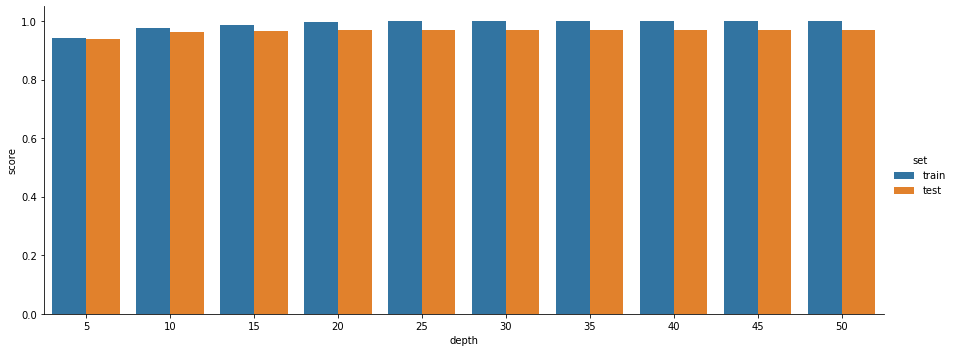

In [69]:
sns.catplot(x = 'depth', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [70]:
best_depth = depths[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['depth'] == best_depth)]['score'])[0]))
rfClf = RandomForestClassifier(max_depth=best_depth, random_state=0)
rfClf.fit(trainX, trainY)

Best depth: 25 with Test Accuracy = 0.9697


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## K nearest neighbor

In [71]:
ks = np.arange(1,51,4)
results = []

for k in tqdm(ks):
    knnClf = KNeighborsClassifier(n_neighbors=k)
    knnClf.fit(trainX.astype('float32'), trainY)
    trainPreds = knnClf.predict(trainX.astype('float32'))
    testPreds = knnClf.predict(testX.astype('float32'))

    results.append({'ks': k, 'set': 'train', 'score': accuracy_score(y_true=trainY, y_pred=trainPreds)})
    results.append({'ks': k, 'set': 'test', 'score': accuracy_score(y_true=testY, y_pred=testPreds)})
    
results = pd.DataFrame(results)

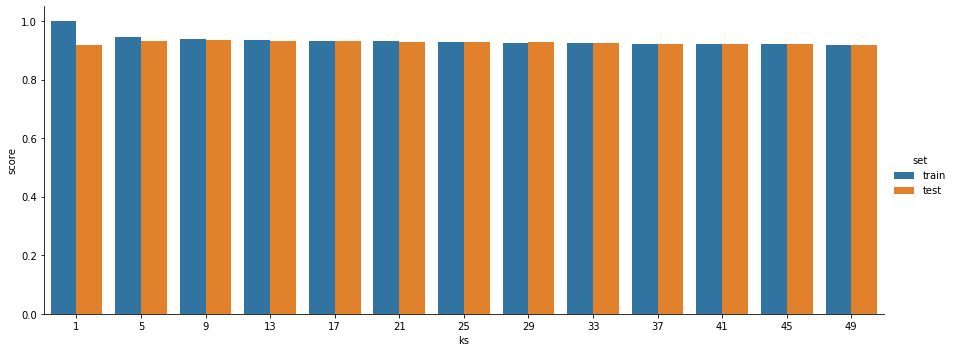

In [72]:
sns.catplot(x = 'ks', y = 'score', hue='set', data=results, kind = 'bar', aspect=2.5)

In [73]:
best_k = ks[np.argsort(results.loc[(results['set'] == 'test')]['score'])[::-1]][0]
print('Best depth: {} with Test Accuracy = {:.4f}'.format(best_depth, 
                                                      np.array(results.loc[(results['set'] == 'test') & 
                                                                  (results['ks'] == best_depth)]['score'])[0]))
knnClf = KNeighborsClassifier(n_neighbors=best_k)
knnClf.fit(trainX.astype('float32'), trainY)

Best depth: 25 with Test Accuracy = 0.9291


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

## Smoothing with HMM

In [74]:
dataHTrain = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,3]])
dataHTrain.drop('Unnamed: 0', axis=1, inplace=True)
dataHTrain.drop('timestamp', axis=1, inplace=True)
dataHTest = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [2]])
dataHTest.drop('Unnamed: 0', axis=1, inplace=True)
dataHTest.drop('timestamp', axis=1, inplace=True)

In [75]:
trainHX = dataHTrain.drop('label', axis=1)
trainHY = dataHTrain['label']

testHX = dataHTest.drop('label', axis=1)
testHY = dataHTest['label']

In [76]:
class smoothHMM:

    def __init__(self, predictor, state_names):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names

    def fit(self, X, y):
        
        X_simplified = self.le.fit_transform(self.predictor.predict(X)).reshape(1, -1)
        
        y = y.to_numpy().reshape(1, -1)

        self.modelHMM = self.modelHMM.from_samples(DiscreteDistribution, len(self.state_names), X_simplified, labels = y,
                                   algorithm='labeled', state_names=self.state_names , verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):

        X_simplified = self.le.transform(self.predictor.predict(X)).tolist()
        
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)
        
        y = self.le.transform(y.to_numpy())
        
        return np.sum(target==y)/y.shape[0]

### KNN SMOOTHING

In [82]:
hmm = smoothHMM(knnClf, state_names=['music', 'speech'])
hmm.fit(trainHX, trainHY)
print('KNN ACCURACY AFTER SMOOTHING = {}'.format(hmm.score(testHX, testHY)))

[1] Improvement: 10167.535833673714	Time (s): 0.01637
[2] Improvement: 0.0	Time (s): 0.01692
Total Training Improvement: 10167.535833673714
Total Training Time (s): 0.0502
KNN ACCURACY AFTER SMOOTHING = 0.9423785947540293


In [84]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

### KNN SMOOTHING

In [83]:
hmm = smoothHMM(rfClf, state_names=['music', 'speech'])
hmm.fit(trainHX, trainHY)
hmm.score(testHX, testHY)
print('rfClf ACCURACY AFTER SMOOTHING = {}'.format(hmm.score(testHX, testHY)))

[1] Improvement: 12685.21459407028	Time (s): 0.01648
[2] Improvement: 0.0	Time (s): 0.0164
Total Training Improvement: 12685.21459407028
Total Training Time (s): 0.0498
rfClf ACCURACY AFTER SMOOTHING = 0.9958917096808174


In [85]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

# Learning & Evaluation - Unsupervised - Preprocessing 2

In [87]:
REPO_DIR = "/mnt/c/Users/zobni/Programming/UWrMLProjectAudioSeg/"

In [88]:
data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2,3]])
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [89]:
data.head(5)

,label,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,music,0.012444,0.081449,432.529692,424.989395,949.418501,0.01466,-632.946411,12.773681,-1.715082,...,-2.038454,-0.884550,-1.802255,0.243648,-0.727257,0.287844,0.141726,-0.364878,-0.763656,-0.566740
4,music,0.172535,0.435161,2309.434221,2392.904163,4963.403320,0.10235,-33.924923,96.108818,-15.746825,...,-10.182379,-11.484722,-13.531470,-5.707917,-9.890487,-1.513985,-8.121307,-4.673933,-4.060278,-2.206214


In [90]:
X = data.drop('label', axis=1)
y = data['label']

X_ = X.copy()
y_ = y.copy()

scaler = StandardScaler()
scaler.fit(X_)
X_ = scaler.transform(X_)
y_ = np.array(y_)

np.reshape(X_, X_.shape, order='C')
np.reshape(y_, y_.shape, order='C')

X_ = X_.astype('float32') # This X_ will be used to train classifiers a.k.a developments set, it is standarndized!!!

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.3, random_state=42, shuffle=False)

In [96]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_redo)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        preds = self.kmeans.index.search(X.astype(np.float32), 1)[1]
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({1: 'music', 0: 'speech'}))

In [97]:
class SklearnKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300, initialization='random'):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        self.initialization = initialization
        
        self.kmeans = None
        self.cluster_centers_ = None

    def fit(self, X):
        self.kmeans = KMeans(n_clusters=self.n_clusters, 
                             random_state=0, 
                             init=self.initialization, 
                             n_init=self.n_redo, max_iter=self.max_iter)
        
        self.kmeans.fit(X)
        self.cluster_centers_ = self.kmeans.cluster_centers_

    def predict(self, X):
        preds = self.kmeans.predict(X)
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({0: 'music', 1: 'speech'}))

In [100]:
K  = 2

kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
kmeansFaiss.fit(X_train)
y_pred_faiss_train = kmeansFaiss.predict(X_train)
y_pred_faiss_test = kmeansFaiss.predict(X_test)


# initialization_methods = ['random', 'k-means++']
# for init_method in initialization_methods:
#     pass
kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
kmeansSklearn.fit(X_train)
y_pred_sklearn_train = kmeansSklearn.predict(X_train)
y_pred_sklearn_test = kmeansSklearn.predict(X_test)

In [101]:
trainAccuracies = {
    'sklearn': accuracy_score(y_true=Y_train, y_pred=y_pred_sklearn_train),
    'faiss': accuracy_score(y_true=Y_train, y_pred=y_pred_faiss_train)
}
trainAccuracies

{'sklearn': 0.1960699736400671, 'faiss': 0.18389647735442127}

In [102]:
testAccuracies = {
    'sklearn': accuracy_score(y_true=Y_test, y_pred=y_pred_sklearn_test),
    'faiss': accuracy_score(y_true=Y_test, y_pred=y_pred_faiss_test)
}
testAccuracies

{'sklearn': 0.20004472772000448, 'faiss': 0.19892653471989266}

In [104]:
faiss_train_accuracies = []
sklearn_train_accuracies = []

faiss_test_accuracies = []
sklearn_test_accuracies = []

faiss_train_accuracies_dict = {}
sklearn_train_accuracies_dict = {}

faiss_test_accuracies_dict = {}
sklearn_test_accuracies_dict = {}

K = 2
n_features = data.shape[1]  # We have 26 features.
principal_components = np.arange(2, n_features, 1)

for principal_component in tqdm(principal_components):
    pca = PCA(n_components=principal_component)
    # use fit_transform to run PCA on our standardized matrix
    X_pcaed = pca.fit_transform(X_)
    trainX, testX, trainY, testY = train_test_split(
        X_pcaed, y_, test_size = 0.3, shuffle=False)
    
    kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
    kmeansFaiss.fit(trainX)
    y_pred_faiss_train = kmeansFaiss.predict(trainX)
    y_pred_faiss_test = kmeansFaiss.predict(testX)
    
    curr_train_acc_faiss = accuracy_score(y_true=trainY, y_pred=y_pred_faiss_train)
    if curr_train_acc_faiss < 0.35:
        curr_train_acc_faiss = 1 - curr_train_acc_faiss
    
    curr_test_acc_faiss = accuracy_score(y_true=testY, y_pred=y_pred_faiss_test)
    if curr_test_acc_faiss < 0.35:
        curr_test_acc_faiss = 1 - curr_test_acc_faiss
    
    faiss_train_accuracies.append(curr_train_acc_faiss)
    faiss_test_accuracies.append(curr_test_acc_faiss)
    
    faiss_train_accuracies_dict[str(principal_component)] = curr_train_acc_faiss
    faiss_test_accuracies_dict[str(principal_component)] = curr_test_acc_faiss
    
    
    kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
    kmeansSklearn.fit(trainX)
    y_pred_sklearn_train = kmeansSklearn.predict(trainX)
    y_pred_sklearn_test = kmeansSklearn.predict(testX)
    
    curr_train_acc = accuracy_score(y_true=trainY, y_pred=y_pred_sklearn_train)
    if curr_train_acc < 0.35:
        curr_train_acc = 1 - curr_train_acc
    
    curr_test_acc = accuracy_score(y_true=testY, y_pred=y_pred_sklearn_test)
    if curr_test_acc < 0.35:
        curr_test_acc = 1 - curr_test_acc
    
    sklearn_train_accuracies.append(curr_train_acc)
    sklearn_test_accuracies.append(curr_test_acc)
    
    sklearn_train_accuracies_dict[str(principal_component)] = curr_train_acc
    sklearn_test_accuracies_dict[str(principal_component)] = curr_test_acc

In [105]:
print('Faiss train accuracies:')
print(faiss_train_accuracies_dict)

Faiss train accuracies:
{'2': 0.7960220464893362, '3': 0.8080517613227893, '4': 0.819027078840163, '5': 0.8221902707884017, '6': 0.8218068535825546, '7': 0.8221423436376707, '8': 0.8227174694464414, '9': 0.822429906542056, '10': 0.8227653965971723, '11': 0.8227174694464414, '12': 0.8212317277737838, '13': 0.8205128205128205, '14': 0.8238197939132519, '15': 0.8203690390606279, '16': 0.8114545890246825, '17': 0.8130841121495327, '18': 0.8120297148334531, '19': 0.8117900790797987, '20': 0.8162473040977714, '21': 0.8161035226455787, '22': 0.8158638868919242, '23': 0.8159597411933861, '24': 0.8159118140426551, '25': 0.8161035226455787, '26': 0.8161035226455787}


In [106]:
print('Faiss test accuracies:')
print(faiss_test_accuracies_dict)

Faiss test accuracies:
{'2': 0.7884378843788438, '3': 0.7988370792798837, '4': 0.8031980319803198, '5': 0.8001789108800179, '6': 0.800849826680085, '7': 0.8010734652801074, '8': 0.8012971038801298, '9': 0.8009616459800961, '10': 0.8017443810801744, '11': 0.8018562003801857, '12': 0.800849826680085, '13': 0.8007380073800738, '14': 0.8019680196801968, '15': 0.8011852845801185, '16': 0.7999552722799955, '17': 0.8004025494800402, '18': 0.7995079950799509, '19': 0.8000670915800067, '20': 0.8009616459800961, '21': 0.8010734652801074, '22': 0.8009616459800961, '23': 0.8009616459800961, '24': 0.8010734652801074, '25': 0.8010734652801074, '26': 0.8010734652801074}


In [107]:
print('Sklearn train accuracies:')
print(sklearn_train_accuracies_dict)

Sklearn train accuracies:
{'2': 0.7843757488617301, '3': 0.7945363048166787, '4': 0.7972681524083394, '5': 0.8007189072609633, '6': 0.8005271986580398, '7': 0.8002875629043853, '8': 0.800862688713156, '9': 0.8010543973160795, '10': 0.8015336688233885, '11': 0.8016295231248503, '12': 0.8018691588785046, '13': 0.8018691588785046, '14': 0.8015815959741194, '15': 0.8015336688233885, '16': 0.8014857416726575, '17': 0.802588066139468, '18': 0.8028277018931225, '19': 0.8035466091540858, '20': 0.8037862449077402, '21': 0.8041217349628564, '22': 0.8039779535106638, '23': 0.8045530793194344, '24': 0.8045530793194344, '25': 0.8039300263599329, '26': 0.8039300263599329}


In [108]:
print('Sklearn test accuracies:')
print(sklearn_test_accuracies_dict)

Sklearn test accuracies:
{'2': 0.7907860896790786, '3': 0.8010734652801074, '4': 0.8016325617801633, '5': 0.7993961757799396, '6': 0.7997316336799731, '7': 0.7997316336799731, '8': 0.7990607178799061, '9': 0.7991725371799172, '10': 0.7990607178799061, '11': 0.7990607178799061, '12': 0.7992843564799285, '13': 0.7991725371799172, '14': 0.7993961757799396, '15': 0.7991725371799172, '16': 0.7989488985798949, '17': 0.7998434529799844, '18': 0.7997316336799731, '19': 0.7998434529799844, '20': 0.7998434529799844, '21': 0.800290730180029, '22': 0.800290730180029, '23': 0.800290730180029, '24': 0.800290730180029, '25': 0.7999552722799955, '26': 0.7999552722799955}


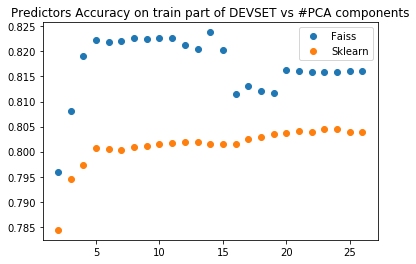

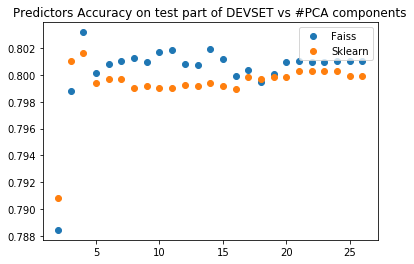

In [109]:
plt.plot(principal_components, faiss_train_accuracies, 'o')
plt.plot(principal_components, sklearn_train_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on train part of DEVSET vs #PCA components')
plt.show()

plt.plot(principal_components, faiss_test_accuracies, 'o')
plt.plot(principal_components, sklearn_test_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on test part of DEVSET vs #PCA components')
plt.show()

In [110]:
num_components = 4
K = 2
pca = PCA(n_components=num_components)
# use fit_transform to run PCA on our standardized matrix
X_pcaed = pca.fit_transform(X_) 
#     print(X_pcaed.shape)
trainX, testX, trainY, testY = train_test_split(
    X_pcaed, y_, test_size = 0.3, shuffle=False)

kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
kmeansFaiss.fit(trainX)
y_pred_faiss_train = kmeansFaiss.predict(trainX)
y_pred_faiss_test = kmeansFaiss.predict(testX)

kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
kmeansSklearn.fit(trainX)
y_pred_sklearn_train = kmeansSklearn.predict(trainX)
y_pred_sklearn_test = kmeansSklearn.predict(testX)

In [111]:
class smoothHMM:

    def __init__(self, predictor, state_names, pca_n=4):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names
        self.pca = PCA(n_components=pca_n)
        self.scaler = StandardScaler()

    def fit(self, X, y):
        
        X_ = X.copy()
        y_ = y.copy()

        self.scaler.fit(X_)
        X_ = self.scaler.transform(X_)
        y_ = np.array(y_)
              
        # use fit_transform to run PCA on our standardized matrix
        X_ = self.pca.fit_transform(X_)
        
        np.reshape(X_, X_.shape, order='C')
        np.reshape(y_, y_.shape, order='C')
        
        X_ = X_.astype('float32')
        X_simplified = self.le.fit_transform(self.predictor.predict(X_)).reshape(1, -1)
        y_simplified = y_.reshape(1, -1)
    
        self.modelHMM = self.modelHMM.from_samples(
            DiscreteDistribution, len(self.state_names), X_simplified, labels = y_simplified,
            algorithm='labeled', state_names=self.state_names , verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):
        
        X_ = X.copy()
        
        self.scaler.fit(X_)
        X_ = self.scaler.transform(X_)
              
        # use fit_transform to run PCA on our standardized matrix
        X_ = self.pca.fit_transform(X_)
        
        np.reshape(X_, X_.shape, order='C')
        
        X_ = X_.astype('float32')
            
        X_simplified = self.le.transform(self.predictor.predict(X_)).tolist()
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)    
        y = self.le.transform(y.to_numpy())
        
        return np.sum(target==y)/y.shape[0]

## Test data load

In [ ]:
dataHTrain = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
dataHTrain.drop('Unnamed: 0', axis=1, inplace=True)
dataHTrain.drop('timestamp', axis=1, inplace=True)
dataHTest = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [3]])
dataHTest.drop('Unnamed: 0', axis=1, inplace=True)
dataHTest.drop('timestamp', axis=1, inplace=True)

## Performance tests on test sets

In [112]:
hmm_faiss = smoothHMM(kmeansFaiss, state_names=['music', 'speech'], pca_n=4)
hmm_faiss.fit(trainHX, trainHY)
print('Faiss library classifier score:', hmm_faiss.score(testHX, testHY))

[1] Improvement: 5469.0404691116655	Time (s): 0.01627
[2] Improvement: 0.0	Time (s): 0.01606
Total Training Improvement: 5469.0404691116655
Total Training Time (s): 0.0496
Faiss library classifier score: 0.8803328768566312


In [114]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1

In [113]:
hmm_sklearn = smoothHMM(kmeansSklearn, state_names=['music', 'speech'], pca_n=4)
hmm_sklearn.fit(trainHX, trainHY)
print('Sklearn library classifier score:', hmm_sklearn.score(testHX, testHY))

[1] Improvement: 5317.848837862015	Time (s): 0.01576
[2] Improvement: 0.0	Time (s): 0.01623
Total Training Improvement: 5317.848837862015
Total Training Time (s): 0.0485
Sklearn library classifier score: 0.8705361845570421


In [115]:
hmm.modelHMM.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.9885433715220949,
                 "1" : 0.011456628477905073
             }
         ],
         "frozen" : false
     },
     "name" : "music",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "numpy.int64",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.01550180408926901,
                 "1" : 0.984498195910731
             }
         ],
         "frozen" : false
     },
     "name" : "speech",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 },
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-end",
     "weight" : 1